In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap
from scipy.spatial.distance import cdist
import anndata
import scanpy as sc
import scvi
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
# from egd_model import MULTIVI

In [2]:
adata = anndata.read("../Data/adata_raw?.h5ad.gz")

/root/miniconda3/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [ ]:
def depair_anndata(adata, n_unpaired):
    modality_switch = np.where(adata.var.modality == "Peaks")[0].min()
    
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    unpaired_idx = indices[:n_unpaired]
    paired_idx = indices[n_unpaired:]
    
    adata_p = adata[paired_idx].copy()
    adata_np_acc = adata[unpaired_idx].copy()
    adata_np_exp = adata_np_acc.copy()
    
    adata_np_acc.X[:, :modality_switch] = 0
    adata_np_exp.X[:, modality_switch:] = 0
    
    adata = anndata.AnnData(
        scipy.sparse.vstack((adata_p.X, adata_np_acc.X, adata_np_exp.X)),
        obs=pd.concat((adata_p.obs, adata_np_acc.obs, adata_np_exp.obs)),
        var=adata_p.var
    )
    adata.X.eliminate_zeros()
    
    has_chr = np.asarray(adata.X[:, modality_switch:].sum(axis=1) > 0).squeeze()
    has_rna = np.asarray(adata.X[:, :modality_switch].sum(axis=1) > 0).squeeze()
    adata.obs["modality"] = "expression"
    adata.obs.modality.loc[has_chr] = "accessibility"
    adata.obs.modality.loc[np.logical_and(has_chr, has_rna)] = "paired"
    return adata.copy()

def corrupt_and_process(adata, unpaired_rate):
    if os.path.exists("../Data/multivi_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100))):
        print("already done, skipping!")
        return
    print("corrupting AnnData...")
    adata = depair_anndata(adata, int(unpaired_rate * adata.shape[0]))
    print("training model...")
    scvi.model.MULTIVI.setup_anndata(adata, batch_key='modality')
    mvi = scvi.model.MULTIVI(adata, 
                    (adata.var.modality=='Gene Expression').sum(), 
                    (adata.var.modality=='Peaks').sum(),
                 )
    mvi.train(adversarial_mixing=True)
    mvi.save("../model_trained/multivi_corruption/mvi_r{}".format(int(unpaired_rate * 100)))
    adata.obsm["X_MultiVI"] = mvi.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_MultiVI")
    sc.tl.umap(adata, min_dist=0.2)
    adata.write("../Data/multivi_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100)), compression='gzip')

In [5]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs:
    print(npp)
    corrupt_and_process(adata, npp)

0.0
already done, skipping!
0.01
already done, skipping!
0.1
already done, skipping!
0.25
already done, skipping!
0.5
already done, skipping!
0.75
corrupting AnnData...


KeyboardInterrupt: 

0.0


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


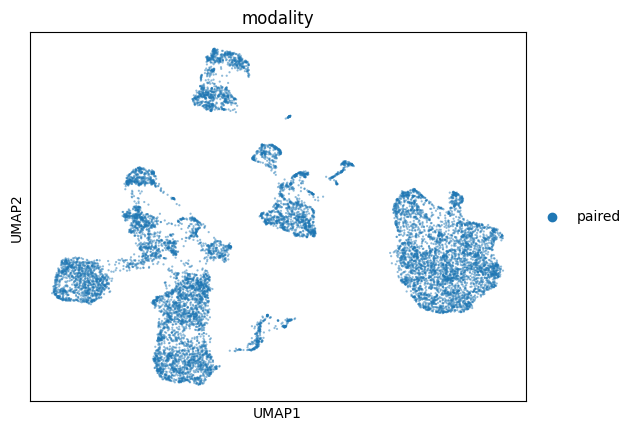

0.01


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


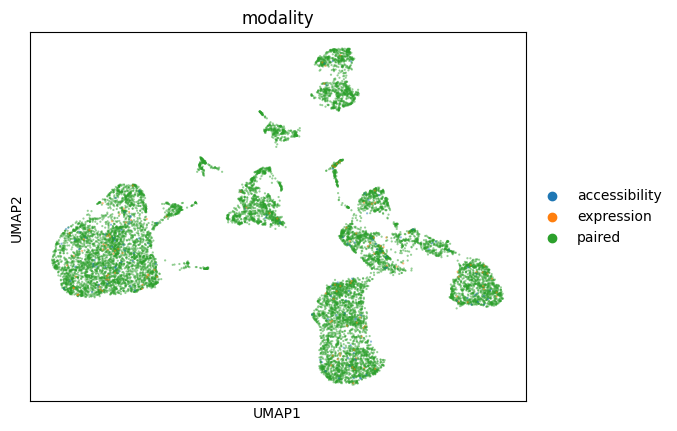

0.1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


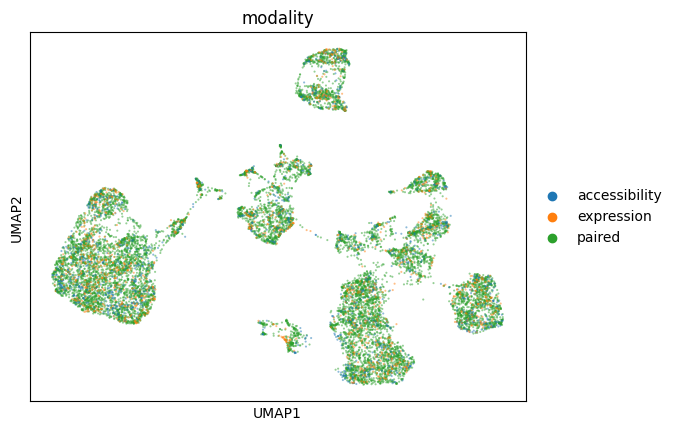

0.25


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


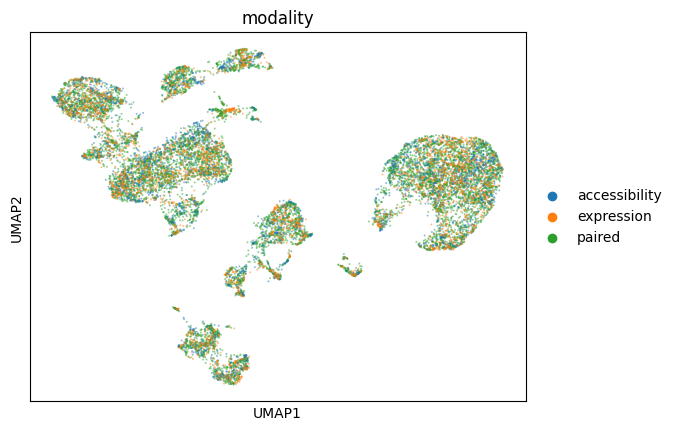

0.5


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


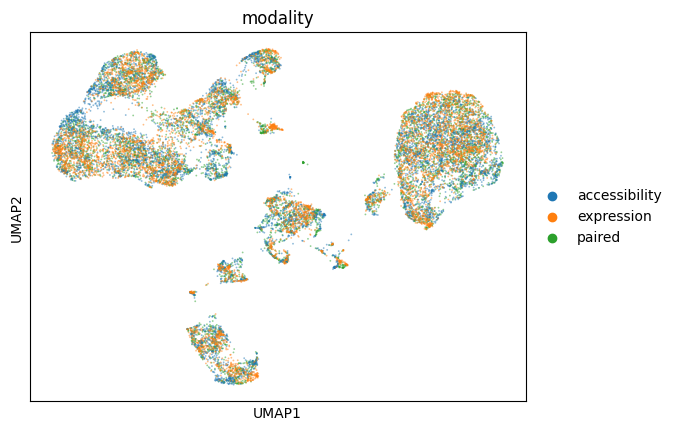

0.75


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


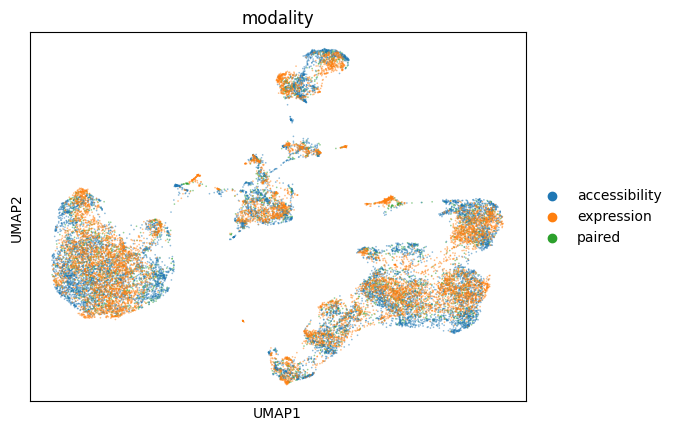

0.9


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


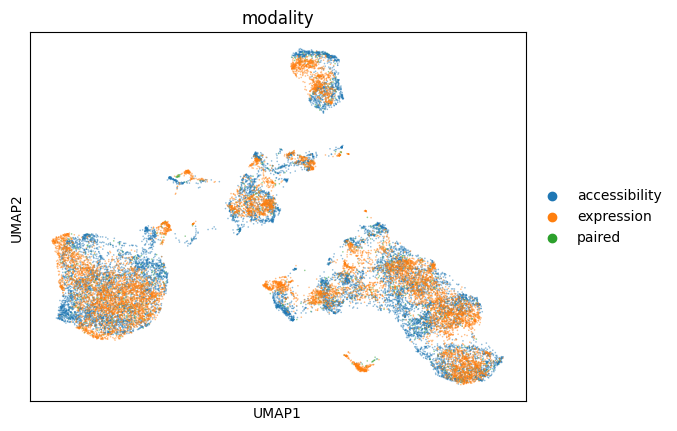

0.99


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


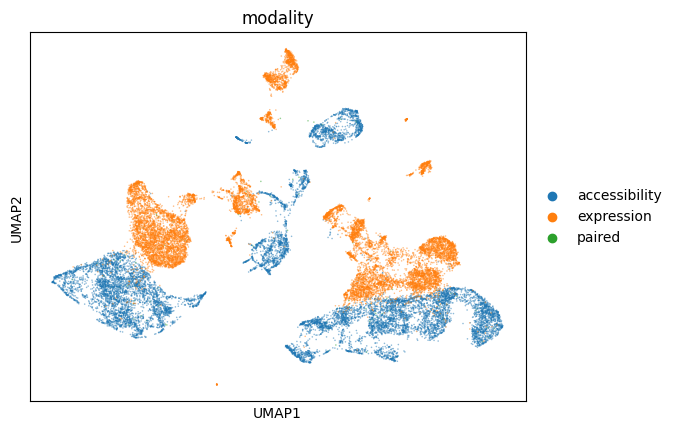

1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


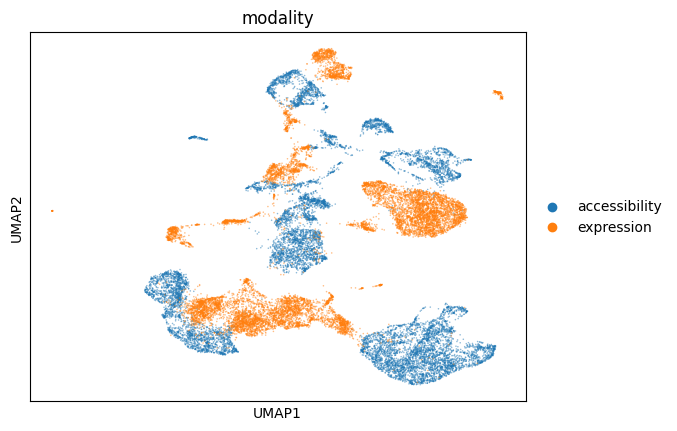

In [3]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs:
    print(npp)
    adata = anndata.read("../Data/corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    sc.pl.umap(adata, color='modality', alpha=0.5)

In [4]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [5]:
def compute_foscttm(latent_acc, latent_exp):
    """
    计算 FOSCTTM 分数
    
    返回: 平均 FOSCTTM 值
    """
    distances = cdist(latent_acc, latent_exp, metric='euclidean')  # 计算所有细胞的欧式距离
    foscttm_values = []
    num_cells=latent_exp.shape[0]

    for i in range(num_cells):  # 遍历所有已知匹配的细胞对
        d_true = distances[i, i]  # 真实匹配的距离
        d_others = distances[i, :]  # 该细胞到所有其他细胞的距离
        
        rank = np.sum(d_others < d_true) / num_cells  # 计算 FOSCTTM
        foscttm_values.append(rank)

    return np.mean(foscttm_values)  # 返回平均 FOSCTTM 值

In [6]:
distances = []
enrichments = []
foscttms=[]
asw_modality=[]
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs[1:-1]:
    print(npp)
    adata = anndata.read_h5ad("../Data/corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    latent = adata.obsm['X_MultiVI']
    for K in [15,50,150,500]:
        print(K)
        enrichments.append((
            npp, 
            K, 
            compute_batch_mixing(latent, adata.obs.modality, K),
        ))
    latent_exp = latent[adata.obs.modality == 'expression']
    latent_acc = latent[adata.obs.modality == 'accessibility']
    distances.append(pd.DataFrame({
        'rate':npp,
        'distances':(((latent_exp - latent_acc) ** 2).sum(axis=1) ** 0.5),
    }))
    foscttms.append((npp,compute_foscttm(latent_acc,latent_exp)))
    asw_modality.append((npp,silhouette_score(latent, adata.obs["modality"], metric='euclidean')))

0.01


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.25


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.5


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.75


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.9


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.99


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500


<Axes: xlabel='rate', ylabel='enrichment'>

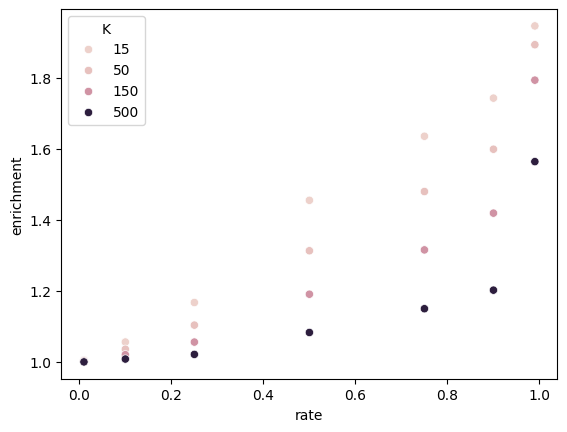

In [21]:
df_enrich = pd.DataFrame(enrichments, columns=('rate', 'K', 'enrichment'))
sns.scatterplot(data=df_enrich, x='rate', y='enrichment', hue='K')

In [10]:
[x[2] for x in enrichments if x[1] == 500]

[0.9988546597154991,
 1.0069971653987284,
 1.0201065601065602,
 1.08192007992008,
 1.1489723960250275,
 1.2013738872944648,
 1.5640425168379233]

In [19]:
dist_mean = [distances[0].distances.mean(), distances[1].distances.mean(), distances[2].distances.mean(), distances[3].distances.mean(), 
             distances[4].distances.mean(), distances[5].distances.mean(), distances[6].distances.mean()]
dist_mean

[1.6812032, 1.8517109, 2.1042674, 2.1384299, 2.492821, 3.0091856, 3.9761043]

<Axes: xlabel='rate', ylabel='distances'>

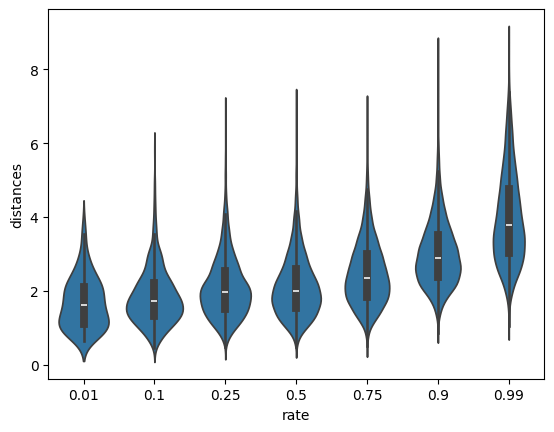

In [22]:
dist_df = pd.concat(distances)
sns.violinplot(data=dist_df, x='rate', y='distances')

In [23]:
foscttms

[(0.01, 0.03395833333333333),
 (0.1, 0.03521628174134654),
 (0.25, 0.0355677178854002),
 (0.5, 0.03806469365909925),
 (0.75, 0.04558814848525138),
 (0.9, 0.05501070975327775),
 (0.99, 0.16979089369654266)]

In [24]:
asw_modality

[(0.01, -0.03592375),
 (0.1, -0.011818329),
 (0.25, -0.015978653),
 (0.5, -0.005728671),
 (0.75, -0.002924665),
 (0.9, -0.002151431),
 (0.99, -0.011867878)]

## Figure

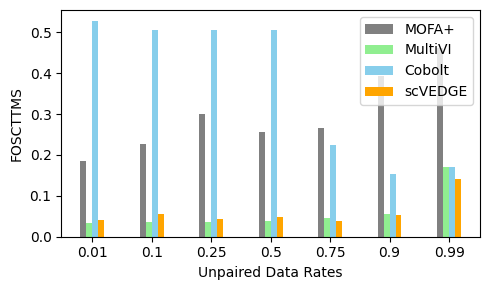

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 类别标签
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]

tmp = [(0.01, 0.184375),
       (0.1, 0.22681140681405515),
       (0.25, 0.29946477099324254),
       (0.5, 0.25643240653230664),
       (0.75, 0.2656715517188378),
       (0.9, 0.3935949428399544),
       (0.99, 0.46124283493095525)]

# 四组数据
values_mofa = [x[1] for x in tmp]
values_vi = [0.03395833333333333, 0.03521628174134654, 0.0355677178854002,
             0.03806469365909925, 0.04558814848525138, 0.05501070975327775, 0.16979089369654266]
values_cobolt = [0.5279166666666666, 0.5061304034037691, 0.5045288821512598,
                 0.5045211753503462, 0.22420573469524518, 0.15336991393688476, 0.16990360560786066]
values_my = [0.04111111111111111, 0.05460409414580272, 0.04388185906667426,
             0.0478248580146682, 0.03777542372280967, 0.05399786575112467, 0.141858036161605]

# 设置柱子的宽度和位置
x = np.arange(len(NPPs))
width = 0.1  # 缩小宽度以适配四组

# 创建图形
plt.figure(figsize=(5, 3))
plt.bar(x - 1.5*width, values_mofa, width, label='MOFA+', color='gray')
plt.bar(x - 0.5*width, values_vi, width, label='MultiVI', color='lightgreen')
plt.bar(x + 0.5*width, values_cobolt, width, label='Cobolt', color='skyblue')
plt.bar(x + 1.5*width, values_my, width, label='scVEDGE', color='orange')

# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('FOSCTTMS')
plt.xticks(x, NPPs)
plt.legend()

plt.tight_layout()
plt.show()


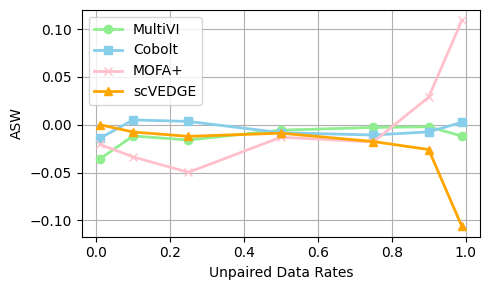

In [12]:
import numpy as np

# 类别标签
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
tmp = [(0.01, -0.020538982),
 (0.1, -0.033651024),
 (0.25, -0.049805216),
 (0.5, -0.013127021),
 (0.75, -0.018004805),
 (0.9, 0.02866995),
 (0.99, 0.10910582)]
# 三组数据
values_mofa = [x[1] for x in tmp]
values_vi = [-0.03592375, -0.011818329,-0.015978653, -0.005728671,-0.002924665, -0.002151431, -0.011867878]
values_cobolt = [-0.01426668,0.0049984218,0.0033660715,-0.008366537,-0.010791562,-0.0075466847,0.0024851433]
values_my = [2.570558e-05, -0.007653988, -0.012206165,-0.008862743, -0.017612107, -0.02598193, -0.10634749]
# 创建图形
plt.figure(figsize=(5, 3))

# 绘制三条线
plt.plot(NPPs, values_vi, marker='o', label='MultiVI', color='lightgreen', linewidth=2)
plt.plot(NPPs, values_cobolt, marker='s', label='Cobolt', color='skyblue', linewidth=2)
plt.plot(NPPs, values_mofa, marker='x', label='MOFA+', color='pink', linewidth=2)
plt.plot(NPPs, values_my, marker='^', label='scVEDGE', color='orange', linewidth=2)

# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('ASW')
#plt.title('Line Plot of FOSCTTMS vs Unpaired Data Rates')
plt.legend()
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()

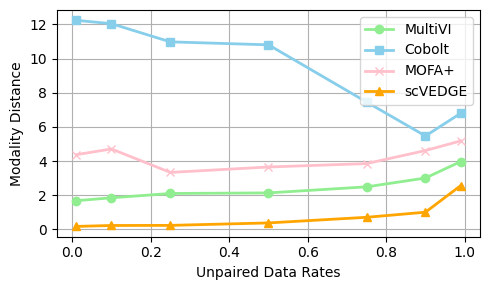

In [13]:
import numpy as np

# 类别标签
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
tmp = [np.float32(12.24396),
 np.float32(12.04545),
 np.float32(10.981727),
 np.float32(10.807638),
 np.float32(7.4589777),
 np.float32(5.471498),
 np.float32(6.803792)]
# 三组数据
values_mofa = [4.3750405, 4.7107196, 3.337152, 3.6549342, 3.8541944, 4.618994, 5.1828327]
values_vi = [1.6812032, 1.8517109, 2.1042674, 2.1384299, 2.492821, 3.0091856, 3.9761043]
values_cobolt = [float(x) for x in tmp]
values_my = [0.17585084,
 0.23044583,
 0.23667149,
 0.38048637,
 0.7099499,
 1.0085211,
 2.5686994]
# 创建图形
plt.figure(figsize=(5, 3))

# 绘制三条线
plt.plot(NPPs, values_vi, marker='o', label='MultiVI', color='lightgreen', linewidth=2)
plt.plot(NPPs, values_cobolt, marker='s', label='Cobolt', color='skyblue', linewidth=2)
plt.plot(NPPs, values_mofa, marker='x', label='MOFA+', color='pink', linewidth=2)
plt.plot(NPPs, values_my, marker='^', label='scVEDGE', color='orange', linewidth=2)

# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Modality Distance')
#plt.title('Line Plot of FOSCTTMS vs Unpaired Data Rates')
plt.legend()
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()

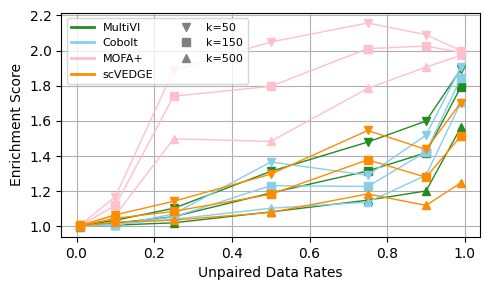

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 类别标签
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]

# 设置颜色映射（按方法）
colors = {
    'MultiVI': 'forestgreen',
    'Cobolt': 'skyblue',
    'MOFA+': 'pink',
    'scVEDGE': 'darkorange'
}

# 设置 marker 映射（按 k 值）
markers = {
    50: 'v',
    150: 's',
    500: '^'
}

# 数据（可进一步整理为 dict 更清晰）
data = {
    'MultiVI': {
        50: [1.0026655814374912, 1.034692027321435, 1.1027184936275845, 1.3125374625374626, 1.479617224880383, 1.5990219271546766, 1.8938962794275915],
        150: [1.0007912264073793, 1.0192198155344474, 1.0548784548784549, 1.18990897990898, 1.3149372265161738, 1.418695809318385, 1.7939330637668296],
        500: [0.9988546597154991, 1.0069971653987284, 1.0201065601065602, 1.08192007992008, 1.1489723960250275, 1.2013738872944648, 1.5640425168379233],
    },
    'Cobolt': {
        50: [1.0016912370289155, 1.0046169778838077, 1.070807979898889, 1.3661704961704964, 1.2905852042694148, 1.5183597450493118, 1.9067231434643297],
        150: [1.0007260413941295, 1.0093941225670404, 1.0532528077982624, 1.2313542013542014, 1.2269185784975258, 1.4244010585086946, 1.8452732012577524],
        500: [1.0004921758641367, 1.0124029514308077, 1.0403496503496503, 1.1030023310023311, 1.1378091031775244, 1.2904382748982464, 1.706653477700786],
    },
    'MOFA+': {
        50: [1.008355546936162, 1.1690721143207712, 1.8884902975812066, 2.0485980685980687, 2.156935345356398, 2.0901107297658887, 1.9994694168222211],
        150: [1.0065909771915234, 1.119245649436872, 1.7404312858858313, 1.7964413364413365, 2.0113842882263935, 2.0254805696254463, 1.9900081677429349],
        500: [1.0040718623286007, 1.0629813293262034, 1.4981460963279145, 1.4831851481851483, 1.7848622254938047, 1.9061473052956568, 1.9723666655736931],
    },
    'scVEDGE': {
        50: [1.0061049485839593, 1.065444482494745, 1.1425665243847063, 1.296836496836497, 1.5453588516746413, 1.4373928257735415, 1.704172625610602],
        150: [1.0043192222999326, 1.0457048352262919, 1.0853227580500306, 1.181989121989122, 1.3785613217192165, 1.2792989343692553, 1.5141773785557937],
        500: [1.0015653270296383, 1.0233989896822733, 1.0351602942512033, 1.0793476523476524, 1.1842117531591216, 1.119290892394598, 1.2477007432183211],
    }
}

# 创建图形
plt.figure(figsize=(5, 3))

# 绘图
for method, k_values in data.items():
    for k, values in k_values.items():
        plt.plot(NPPs, values,
                 color=colors[method],
                 marker=markers[k],
                 linewidth=1,
                 label=None)  # 避免重复图例

# 构造图例：方法图例（颜色）
method_handles = [
    Line2D([0], [0], color=colors['MultiVI'], lw=2, label='MultiVI'),
    Line2D([0], [0], color=colors['Cobolt'], lw=2, label='Cobolt'),
    Line2D([0], [0], color=colors['MOFA+'], lw=2, label='MOFA+'),
    Line2D([0], [0], color=colors['scVEDGE'], lw=2, label='scVEDGE')
]

# 构造图例：k 值图例（marker）
k_handles = [
    Line2D([0], [0], color='gray', marker=markers[50], linestyle='None', label='k=50'),
    Line2D([0], [0], color='gray', marker=markers[150], linestyle='None', label='k=150'),
    Line2D([0], [0], color='gray', marker=markers[500], linestyle='None', label='k=500'),
]

# 添加图例
plt.legend(handles=method_handles + k_handles, loc='upper left', fontsize=8, ncol=2)

# 添加轴标签
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Enrichment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


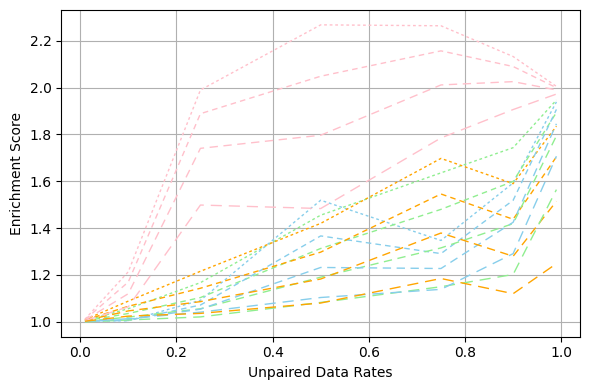

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 类别标签
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]

# k==15
values_mofa = [1.0102819356172013, 1.2129387326506695, 1.9897577170304441, 2.268131868131868, 2.2641884431358115, 2.1327461126071046, 2.0050962426995214]
values_vi = [1.0038091781611713, 1.0550024312140898, 1.1664900755809848, 1.454867354867355, 1.6356193514088253, 1.7432001347774726, 1.9469234504330986]
values_cobolt = [1.0028599928805166, 1.0038035025920977, 1.0909898182625455, 1.518703518703519, 1.3467795362532204, 1.5924684604900536, 1.9389052517315175]
values_my = [1.0082005895801034, 1.0874973122156644, 1.2150475786839423, 1.4197691197691198, 1.6974195395248026, 1.5894016787751444, 1.835108176340218]

# k==50
values_mofa50 = [1.008355546936162, 1.1690721143207712, 1.8884902975812066, 2.0485980685980687, 2.156935345356398, 2.0901107297658887, 1.9994694168222211]
values_vi50 = [1.0026655814374912, 1.034692027321435, 1.1027184936275845, 1.3125374625374626, 1.479617224880383, 1.5990219271546766, 1.8938962794275915]
values_cobolt50 = [1.0016912370289155, 1.0046169778838077, 1.070807979898889, 1.3661704961704964, 1.2905852042694148, 1.5183597450493118, 1.9067231434643297]
values_my50 = [1.0061049485839593, 1.065444482494745, 1.1425665243847063, 1.296836496836497, 1.5453588516746413, 1.4373928257735415, 1.704172625610602]

# k==150
values_mofa150 = [1.0065909771915234, 1.119245649436872, 1.7404312858858313, 1.7964413364413365, 2.0113842882263935, 2.0254805696254463, 1.9900081677429349]
values_vi150 = [1.0007912264073793, 1.0192198155344474, 1.0548784548784549, 1.18990897990898, 1.3149372265161738, 1.418695809318385, 1.7939330637668296]
values_cobolt150 = [1.0007260413941295, 1.0093941225670404, 1.0532528077982624, 1.2313542013542014, 1.2269185784975258, 1.4244010585086946, 1.8452732012577524]
values_my150 = [1.0043192222999326, 1.0457048352262919, 1.0853227580500306, 1.181989121989122, 1.3785613217192165, 1.2792989343692553, 1.5141773785557937]

# k==500
values_mofa500 = [1.0040718623286007, 1.0629813293262034, 1.4981460963279145, 1.4831851481851483, 1.7848622254938047, 1.9061473052956568, 1.9723666655736931]
values_vi500 = [0.9988546597154991, 1.0069971653987284, 1.0201065601065602, 1.08192007992008, 1.1489723960250275, 1.2013738872944648, 1.5640425168379233]
values_cobolt500 = [1.0004921758641367, 1.0124029514308077, 1.0403496503496503, 1.1030023310023311, 1.1378091031775244, 1.2904382748982464, 1.706653477700786]
values_my500 = [1.0015653270296383, 1.0233989896822733, 1.0351602942512033, 1.0793476523476524, 1.1842117531591216, 1.119290892394598, 1.2477007432183211]

# 创建图形
plt.figure(figsize=(6, 4))

# 每个k值使用不同的dashes样式
dashes_15 = (2, 2)
dashes_50 = (4, 3)
dashes_150 = (6, 4)
dashes_500 = (8, 5)

# k=15
plt.plot(NPPs, values_vi, label='MultiVI_15', color='lightgreen', linewidth=1, linestyle='--', dashes=dashes_15)
plt.plot(NPPs, values_cobolt, label='Cobolt_15', color='skyblue', linewidth=1, linestyle='--', dashes=dashes_15)
plt.plot(NPPs, values_mofa, label='MOFA_15', color='pink', linewidth=1, linestyle='--', dashes=dashes_15)
plt.plot(NPPs, values_my, label='scVEDGE_15', color='orange', linewidth=1, linestyle='--', dashes=dashes_15)

# k=50
plt.plot(NPPs, values_vi50, label='MultiVI_50', color='lightgreen', linewidth=1, linestyle='--', dashes=dashes_50)
plt.plot(NPPs, values_cobolt50, label='Cobolt_50', color='skyblue', linewidth=1, linestyle='--', dashes=dashes_50)
plt.plot(NPPs, values_mofa50, label='MOFA_50', color='pink', linewidth=1, linestyle='--', dashes=dashes_50)
plt.plot(NPPs, values_my50, label='scVEDGE_50', color='orange', linewidth=1, linestyle='--', dashes=dashes_50)

# k=150
plt.plot(NPPs, values_vi150, label='MultiVI_150', color='lightgreen', linewidth=1, linestyle='--', dashes=dashes_150)
plt.plot(NPPs, values_cobolt150, label='Cobolt_150', color='skyblue', linewidth=1, linestyle='--', dashes=dashes_150)
plt.plot(NPPs, values_mofa150, label='MOFA_150', color='pink', linewidth=1, linestyle='--', dashes=dashes_150)
plt.plot(NPPs, values_my150, label='scVEDGE_150', color='orange', linewidth=1, linestyle='--', dashes=dashes_150)

# k=500
plt.plot(NPPs, values_vi500, label='MultiVI_500', color='lightgreen', linewidth=1, linestyle='--', dashes=dashes_500)
plt.plot(NPPs, values_cobolt500, label='Cobolt_500', color='skyblue', linewidth=1, linestyle='--', dashes=dashes_500)
plt.plot(NPPs, values_mofa500, label='MOFA_500', color='pink', linewidth=1, linestyle='--', dashes=dashes_500)
plt.plot(NPPs, values_my500, label='scVEDGE_500', color='orange', linewidth=1, linestyle='--', dashes=dashes_500)

# 添加标签和图例
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Enrichment Score')
plt.grid(True)
plt.legend().remove()
plt.tight_layout()
plt.show()


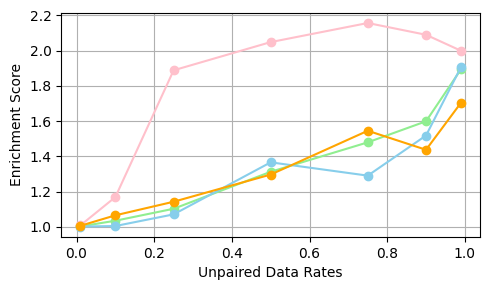

In [15]:
# k==50
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
values_mofa50 = [1.008355546936162, 1.1690721143207712, 1.8884902975812066, 2.0485980685980687, 2.156935345356398, 2.0901107297658887, 1.9994694168222211]
values_vi50 = [1.0026655814374912,
 1.034692027321435,
 1.1027184936275845,
 1.3125374625374626,
 1.479617224880383,
 1.5990219271546766,
 1.8938962794275915]
values_cobolt50 = [1.0016912370289155, 1.0046169778838077, 1.070807979898889, 1.3661704961704964, 1.2905852042694148, 1.5183597450493118, 1.9067231434643297]
values_my50 =[1.0061049485839593,
 1.065444482494745,
 1.1425665243847063,
 1.296836496836497,
 1.5453588516746413,
 1.4373928257735415,
 1.704172625610602]
plt.figure(figsize=(5, 3))
plt.plot(NPPs, values_vi50, marker='o', label='MultiVI_50', color='lightgreen', linewidth=1.5)
plt.plot(NPPs, values_cobolt50, marker='o', label='Cobolt50', color='skyblue', linewidth=1.5)
plt.plot(NPPs, values_mofa50, marker='o', label='MOFA50', color='pink', linewidth=1.5)
plt.plot(NPPs, values_my50, marker='o', label='scVEDGE50', color='orange', linewidth=1.5)


# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Enrichment Score')
#plt.title('Line Plot of FOSCTTMS vs Unpaired Data Rates')
plt.legend().remove()
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()

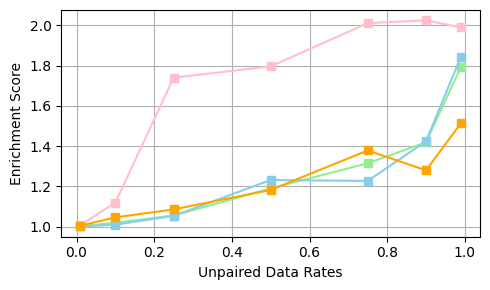

In [16]:
# k==150
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
values_mofa150 = [1.0065909771915234, 1.119245649436872, 1.7404312858858313, 1.7964413364413365, 2.0113842882263935, 2.0254805696254463, 1.9900081677429349]
values_vi150 = [1.0007912264073793,
 1.0192198155344474,
 1.0548784548784549,
 1.18990897990898,
 1.3149372265161738,
 1.418695809318385,
 1.7939330637668296]
values_cobolt150 = [1.0007260413941295, 1.0093941225670404, 1.0532528077982624, 1.2313542013542014, 1.2269185784975258, 1.4244010585086946, 1.8452732012577524]
values_my150 = [1.0043192222999326,
 1.0457048352262919,
 1.0853227580500306,
 1.181989121989122,
 1.3785613217192165,
 1.2792989343692553,
 1.5141773785557937]

plt.figure(figsize=(5, 3))
# 绘制三条线
plt.plot(NPPs, values_vi150, marker='s', label='MultiVI_150', color='lightgreen', linewidth=1.5)
plt.plot(NPPs, values_cobolt150, marker='s', label='Cobolt_150', color='skyblue', linewidth=1.5)
plt.plot(NPPs, values_mofa150, marker='s', label='MOFA_150', color='pink', linewidth=1.5)
plt.plot(NPPs, values_my150, marker='s', label='scVEDGE_150', color='orange', linewidth=1.5)

# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Enrichment Score')
#plt.title('Line Plot of FOSCTTMS vs Unpaired Data Rates')
plt.legend().remove()
plt.grid(True)

# 显示图形
plt.tight_layout()
plt.show()


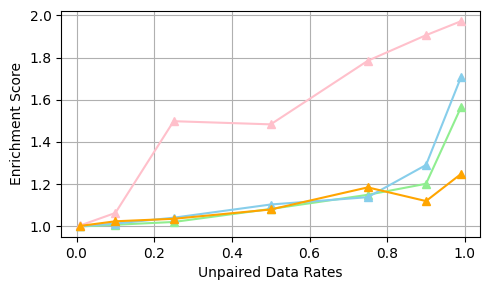

In [17]:
# k==500
NPPs = [0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]
values_mofa500 = [1.0040718623286007, 1.0629813293262034, 1.4981460963279145, 1.4831851481851483, 1.7848622254938047, 1.9061473052956568, 1.9723666655736931]
values_vi500 =[0.9988546597154991,
 1.0069971653987284,
 1.0201065601065602,
 1.08192007992008,
 1.1489723960250275,
 1.2013738872944648,
 1.5640425168379233]
values_cobolt500 = [1.0004921758641367, 1.0124029514308077, 1.0403496503496503, 1.1030023310023311, 1.1378091031775244, 1.2904382748982464, 1.706653477700786]
values_my500 =[1.0015653270296383,
 1.0233989896822733,
 1.0351602942512033,
 1.0793476523476524,
 1.1842117531591216,
 1.119290892394598,
 1.2477007432183211]
plt.figure(figsize=(5, 3))
plt.plot(NPPs, values_vi500, marker='^', label='MultiVI_500', color='lightgreen', linewidth=1.5)
plt.plot(NPPs, values_cobolt500, marker='^', label='Cobolt500', color='skyblue', linewidth=1.5)
plt.plot(NPPs, values_mofa500, marker='^', label='MOFA500', color='pink', linewidth=1.5)
plt.plot(NPPs, values_my500, marker='^', label='scVEDGE500', color='orange', linewidth=1.5)
# 添加标签和标题
plt.xlabel('Unpaired Data Rates')
plt.ylabel('Enrichment Score')
#plt.title('Line Plot of FOSCTTMS vs Unpaired Data Rates')
plt.legend().remove()
plt.grid(True)
# 显示图形
plt.tight_layout()
plt.show()